In [1]:
from collections import namedtuple
from astropy.io.votable import from_table, parse_single_table
from astropy.io import fits
from astropy.table import QTable, Column
from astropy.convolution import convolve
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from RadioAbsTools import cube_tools, spectrum_tools
from astropy.wcs import WCS
import regions
from astropy.coordinates import SkyCoord
import pandas as pd

sns.set()

In [2]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

## Corrected column density
Calculate any stats that depend on the \tau(v) for each spectrum. This includes the corrected column density, equivalent width and the density weighted mean spin temperature. The output of this notebook will be a set of figures for these values as well as an augmented specra catalogue.

### Table of Contents

* [Produce augmented spectra table](#Produce-augmented-spectra-table)
* [Corrected Column Density and R_HI](#Corrected-Column-Density-and-R_HI)
* [Comparison to Galactic Surveys](#Comparison-to-Galactic-Surveys)
* [Equivalent Width and the Kanekar, Braun and Roy 2011 Result](#Equivalent-Width-and-the-Kanekar,-Braun-and-Roy-2011-Result)
* [Mean Spin Temperatures](#Mean-Spin-Temperatures)
* [Cool gas fraction](#Cool-gas-fraction)
* [Effects of Optical Depth Noise](#Effects-of-Optical-Depth-Noise)
* [Comparison plots of the effect of smoothing](#Comparison-plots-of-the-effect-of-smoothing)
* [Scratch](#Scratch)

### Produce augmented spectra table

In [3]:

# Constants

c0 = 1.823 * 10**18

In [4]:
def find_emission_window(abs_spec, vel_range):
    em_idxes = np.where((abs_spec['em_mean'] >= 3) & # K
                        (abs_spec['velocity']/1e3 >= vel_range[0] ) & 
                        (abs_spec['velocity']/1e3 <= vel_range[1]) )
    #print (em_idxes, len(em_idxes[0]), em_idxes[0][0], em_idxes[0][-1])
    if len(em_idxes[0]) < 2:
        return None
    return np.array([em_idxes[0][0], em_idxes[0][-1]])


def calc_tau(min_optical_depth, sigma_min_od):
    if min_optical_depth > 0:
        peak_tau = -1*np.log(min_optical_depth)
        tau_1_sigma = -1*np.log(min_optical_depth + sigma_min_od)
        sigma_peak_tau = np.abs(peak_tau - tau_1_sigma)
        #sigma_peak_tau = np.abs(sigma_min_od / (min_optical_depth))
    else:
        # Saturated spectra defaulting to tau=5 TODO: Check
        peak_tau = 5
        tau_noise = -1* np.log(sigma_min_od)
        sigma_peak_tau = np.abs(peak_tau - tau_noise)
    print ("od={:.3f} +- {:.3f} tau={:.2f} +- {:.2f}".format(
        min_optical_depth, sigma_min_od, peak_tau, sigma_peak_tau))
    return peak_tau, sigma_peak_tau


def calc_bulk_tau(optical_depth, sigma_od):
    od = optical_depth.copy()
    saturated = od <= 0
    od[saturated] = sigma_od[saturated]
    tau = -1*np.log(od)

    with np.errstate(divide='ignore',invalid='ignore'):
        adj_od = od - sigma_od
    adj_od[saturated] = sigma_od[saturated]
    tau_noise = -1* np.log(adj_od)
    sigma_tau = np.abs(tau - tau_noise)
    
    return tau, sigma_tau
    
    
def calc_nh_corr(optical_depth, sigma_od, emission, e_emission):
    corr_od = optical_depth.copy()
    sat_filter = optical_depth <= 0
    corr_od[sat_filter] = sigma_od[sat_filter]
    no_abs_filter = (corr_od == 1)    

    tau, e_tau = calc_bulk_tau(optical_depth, sigma_od)
    corr_nh = c0 * tau*emission / (1-corr_od)
    corr_nh[no_abs_filter] = c0*emission[no_abs_filter] # Fixes the div by 0 channels where there is no absorption

    e_corr_nh_frac = np.sqrt((e_tau/tau)**2 + (e_emission/emission)**2 + (sigma_od/optical_depth)**2)

    e_corr_nh = corr_nh * e_corr_nh_frac

    return corr_nh, e_corr_nh

def calc_rhi(tot_uncorr_nh, e_tot_uncorr_nh, tot_corr_nh, e_tot_corr_nh):
    r_hi = tot_corr_nh / tot_uncorr_nh
    e_r_hi = r_hi * np.sqrt((e_tot_uncorr_nh/tot_uncorr_nh)**2 + (e_tot_corr_nh/tot_corr_nh)**2)
    return r_hi, e_r_hi

def calc_mean_ts(emission, e_emission, corr_od, e_corr_od, vel_filter):
    tot_em = np.sum(emission[vel_filter])
    tot_od = np.sum(1-corr_od[vel_filter])
    mean_ts = tot_em / tot_od
    
    e_tot_em = np.sqrt(np.sum(e_emission[vel_filter]**2))
    e_tot_od = np.sqrt(np.sum(e_corr_od[vel_filter]**2))
    frac_e_mean_ts = np.sqrt((e_tot_em/tot_em)**2 + (e_tot_od/tot_od)**2)
    e_mean_ts = abs(mean_ts) * frac_e_mean_ts
    return mean_ts, e_mean_ts




def process_spectrum(source, spectra_folder, vel_range=(75, 250), plot=False, smooth_thresh=0.04, sigma_clip=1, use_em_filter=True, report_settings=False):
    """
    Produce column density correction measurements for a spectrum. The spectrum will be read in and the emission 
    and absorption compared at each velocity to produce a correction to the 'thin' optical depth assumption 
    column density measured in the emission spectrum.
    """
    if report_settings:
        print ('Spectrum settings: Em box:{}, Smoothing with noise > {}, Sigma Clip: < {} sigma, velocity {} - {} km/s'.format(
                use_em_filter, smooth_thresh, sigma_clip, vel_range[0], vel_range[1]))
    comp_name = source['comp_name']
    abs_spec_filename = '{}/{}_spec.vot'.format(spectra_folder, comp_name)
    abs_spec_votable = parse_single_table(abs_spec_filename)
    abs_spec = abs_spec_votable.to_table()
    abs_velocity = abs_spec['velocity']
    vel_filter = (abs_velocity/1e3 >= vel_range[0] ) & (abs_velocity/1e3 <= vel_range[1])
    optical_depth = np.asarray(abs_spec['opacity'])
    emission = abs_spec['em_mean']
    
    if use_em_filter:
        em_window = find_emission_window(abs_spec, vel_range)
        if em_window is not None:
            vel_filter = (abs_velocity >= abs_velocity[em_window[0]] ) & (abs_velocity <= abs_velocity[em_window[1]])
        else:
            vel_filter = np.full(abs_velocity.shape, False)
    else:
        em_window = None
        vel_filter = (abs_velocity >= abs_velocity[em_window[0]] ) & (abs_velocity <= abs_velocity[em_window[1]])

    num_chan = np.sum(vel_filter)
    # TODO: Handle case of no window foundwith em > 3K

    if source['sd_cont'] > smooth_thresh:
        hann_kernel = np.hanning(5)
        optical_depth = convolve(abs_spec['opacity']*abs_spec['velocity'].unit, hann_kernel)

    corr_od = np.array(optical_depth)

    if sigma_clip:
        noise_filter = (1-optical_depth)< sigma_clip*abs_spec['sigma_opacity']
        corr_od[noise_filter] = 1
    
    sat_filter = optical_depth <= 0
    corr_od[sat_filter] = abs_spec['sigma_opacity'][sat_filter]

    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        fig.suptitle("Correction for " + comp_name)
        axs[0].plot(abs_velocity/1e3, abs_spec['opacity'], label="Original")
        axs[0].plot(abs_velocity/1e3, corr_od, label="Trimmed")
        axs[0].legend()
        axs[0].set_xlabel('Velocity (km/s)')
        axs[0].set_ylabel(r'exp($-\tau$)')
        axs[0].set_xlim(vel_range)
        axs[0].set_title('Absorption')
        if em_window is not None:
            axs[0].vlines(abs_velocity[em_window]/1e3, 0, 1, ls=':')



    #ew = np.sum(-1*np.log(corr_od[vel_filter]))
    tau, e_tau = calc_bulk_tau(optical_depth, abs_spec['sigma_opacity'])
    ew = np.sum(tau[vel_filter])
    e_ew = np.sqrt(np.sum(e_tau[vel_filter]**2))

    n_h = c0 * emission
    no_abs_filter = (corr_od == 1)
    
    # Apply abs correction to GASKAP column density
    #corr_nh = c0 * -1*np.log(corr_od)*emission / (1-corr_od)
    #corr_nh[no_abs_filter] = c0*emission[no_abs_filter] # Fixes the div by 0 channels where there is no absorption
    #e_corr_nh = np.zeros(len(corr_nh))
    
    corr_nh, e_corr_nh = calc_nh_corr(optical_depth, abs_spec['sigma_opacity'], emission, abs_spec['em_std'])
    tot_corr_nh = np.sum(corr_nh[vel_filter])
    e_tot_corr_nh = np.sqrt(np.sum(e_corr_nh[vel_filter]**2))
    
    img_nh = source['nh_gass']
    tot_nh = np.sum(n_h[vel_filter])
    e_tot_nh = c0 * np.sqrt(np.sum(abs_spec['em_std'][vel_filter]**2))


    #r_hi = tot_corr_nh / tot_nh
    r_hi, e_r_hi = calc_rhi(tot_nh, e_tot_nh, tot_corr_nh, e_tot_corr_nh)
    #print ("image n_h = {:.3E} calc n_h = {:.3E} corr n_h= {:.3E} R_HI_corr={:.3f} R_HI_calc={:.3f}".format(img_nh, tot_nh, tot_corr_nh, r_hi, tot_nh/img_nh))

    if plot:
        axs[1].plot(abs_velocity/1e3, n_h, label="Uncorrected")
        axs[1].plot(abs_velocity/1e3, corr_nh, label="Corrected")
        axs[1].legend()
        axs[1].set_xlabel('Velocity (km/s)')
        axs[1].set_ylabel('Column Density')
        axs[1].set_xlim(vel_range)
        axs[1].set_title('Column Density Correction')
        if em_window is not None:
            axs[1].vlines(abs_velocity[em_window]/1e3, 0, np.max(corr_nh), ls=':')


    #mean_ts = np.sum(emission[vel_filter]) / np.sum(1-corr_od[vel_filter])
    mean_ts, e_mean_ts = calc_mean_ts(emission, abs_spec['em_std'], corr_od, abs_spec['sigma_opacity'], vel_filter)

    mean_cont, sd_cont = spectrum_tools.get_mean_continuum(abs_velocity/1000, optical_depth, -100, -60)
    
    # Correction fraction from Dickey et al 2000
    with np.errstate(divide='ignore',invalid='ignore'):
        f_v = -1*np.log(corr_od) / (1-corr_od)
        f_v = np.nan_to_num(f_v, nan=1)
    
    if plot:
        axs[2].plot(abs_velocity/1e3, corr_nh/n_h, label="r_hi")
        axs[2].plot(abs_velocity/1e3, f_v, label="f_v")
        axs[2].legend()
        axs[2].set_xlabel('Velocity (km/s)')
        axs[2].set_ylabel('f$_v$')
        axs[2].set_xlim(vel_range)
        axs[2].set_title('Correction factor')
        if em_window is not None:
            axs[2].vlines(abs_velocity[em_window]/1e3, 1, np.max(f_v), ls=':')


    f_int_v = np.sum(f_v[vel_filter]*emission[vel_filter])/np.sum(emission[vel_filter])

    SpectraStats = namedtuple('SpectraStats', 
                              'img_nh,tot_uncorr_nh,e_tot_uncorr_nh,tot_corr_nh,e_tot_corr_nh,r_hi,e_r_hi,ew,e_ew,mean_ts,e_mean_ts, sd_cont,f_int_v,num_chan')
    
    return SpectraStats(img_nh, tot_nh, e_tot_nh, tot_corr_nh, e_tot_corr_nh, r_hi, e_r_hi, ew, e_ew, mean_ts, e_mean_ts, sd_cont, f_int_v, num_chan)


def read_beam_power(spectra_table):
    power_pat = fits.open('sb10944/SMC_PB_pattern_full.fits')
    power_wcs = WCS(power_pat[0].header).celestial
    pix_pos = power_wcs.wcs_world2pix(spectra_table['ra'], spectra_table['dec'], 0)
    power_vals = power_pat[0].data[0, 0, pix_pos[1].astype(int), pix_pos[0].astype(int)]
    return power_vals

def read_spectra_table(noise_limit=0.3, beam_power_min=0.8):
    spectra_table = parse_single_table('sb10944/v3a/askap_spectra.vot').to_table()
    
    spectra_table.add_column(Column(name='beam_power', data=read_beam_power(spectra_table), 
                                    description='Fraction of primary beam power at this location'))
    
    num_rows = len(spectra_table)
    # Exclude the really noisy spectra
    spectra_table = spectra_table[spectra_table['sd_cont'] < noise_limit]
    spectra_table = spectra_table[spectra_table['beam_power'] > beam_power_min]
    num_excluded = num_rows - len(spectra_table)
    print ("Read {} rows, excluded {} due to noise, leaving {} rows".format(num_rows, num_excluded, len(spectra_table)))


    spectra_table.rename_column('n_h', 'nh_gass')
    
    
    return spectra_table


Read 373 rows, excluded 144 due to noise, leaving 229 rows
Spectrum settings: Em box:True, Smoothing with noise > 20, Sigma Clip: < -20 sigma, velocity 75 - 250 km/s


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


image n_h = 6.946E+21 GASKAP uncorr n_h = 7.435E+21 +- 7.285E+19 corr n_h= 1.024E+22 +- 4.482E+21 R_HI_corr=1.377 +- 6.031E-01 GASKAP/GASS N_H=1.070 f_int(D00)=1.377 ew=3.944877E+01+-5.831247E+00 <T_S>=205.995+-28.627 old sd_cont=0.181 new sd_cont=0.181 chans=106


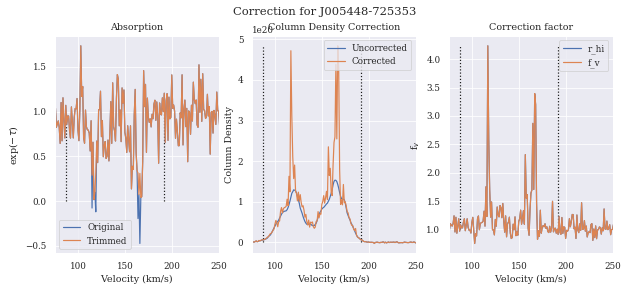

In [5]:
spectra_table = read_spectra_table(noise_limit=0.3)


comp_name = 'J005448-725353'
source = spectra_table[spectra_table['comp_name'] == comp_name]
#img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source[0], 'sb10944/v3a/spectra', plot=True, sigma_clip=-20, use_em_filter=False)
spectra_stats = process_spectrum(source[0], 'sb10944/v3a/spectra', plot=True, sigma_clip=-20, smooth_thresh=20, use_em_filter=True, report_settings=True)
plt.savefig('figures/column_density_processing.png')
print ("image n_h = {:.3E} GASKAP uncorr n_h = {:.3E} +- {:.3E} corr n_h= {:.3E} +- {:.3E} R_HI_corr={:.3f} +- {:.3E} GASKAP/GASS N_H={:.3f} f_int(D00)={:.3f} ew={:3E}+-{:3E} <T_S>={:.3f}+-{:.3f} old sd_cont={:.3f} new sd_cont={:.3f} chans={}".format(
    spectra_stats.img_nh, spectra_stats.tot_uncorr_nh, spectra_stats.e_tot_uncorr_nh, spectra_stats.tot_corr_nh, 
    spectra_stats.e_tot_corr_nh, spectra_stats.r_hi, spectra_stats.e_r_hi, spectra_stats.tot_uncorr_nh/spectra_stats.img_nh, spectra_stats.f_int_v, spectra_stats.ew, spectra_stats.e_ew, 
    spectra_stats.mean_ts, spectra_stats.e_mean_ts, source['sd_cont'][0],spectra_stats.sd_cont, spectra_stats.num_chan))


In [6]:

def add_column_density_to_spectra_table():
    print (len(spectra_table))
    all_tot_uncorr_nh = np.zeros(len(spectra_table))
    all_e_tot_uncorr_nh = np.zeros(len(spectra_table))
    all_corr_nh = np.zeros(len(spectra_table))
    all_e_corr_nh = np.zeros(len(spectra_table))
    all_img_nh = np.zeros(len(spectra_table))
    all_r_hi = np.zeros(len(spectra_table))
    all_e_r_hi = np.zeros(len(spectra_table))
    all_ew = np.zeros(len(spectra_table))
    all_e_ew = np.zeros(len(spectra_table))
    all_mean_ts = np.zeros(len(spectra_table))
    all_e_mean_ts = np.zeros(len(spectra_table))
    all_sd_cont = np.zeros(len(spectra_table))
    all_f_int =  np.zeros(len(spectra_table))
    all_num_chan = np.zeros(len(spectra_table))


    for idx, source in enumerate(spectra_table):
        if idx % 50 == 0:
            print ('processing record {} of {}'.format(idx+1, len(spectra_table)))
        #img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source, 'sb10944/v3a/spectra', sigma_clip=-20, use_em_filter=False)
        spectra_stats = process_spectrum(source, 'sb10944/v3a/spectra', sigma_clip=-20, smooth_thresh=20, use_em_filter=True, report_settings=idx==0)
        if spectra_stats is None or spectra_stats.r_hi is None:
            print (source['comp_name'])
        all_tot_uncorr_nh[idx] = spectra_stats.tot_uncorr_nh
        all_e_tot_uncorr_nh[idx] = spectra_stats.e_tot_uncorr_nh
        all_corr_nh[idx] = spectra_stats.tot_corr_nh
        all_e_corr_nh[idx] = spectra_stats.e_tot_corr_nh
        all_img_nh[idx] = spectra_stats.img_nh
        all_r_hi[idx] = spectra_stats.r_hi
        all_e_r_hi[idx] = spectra_stats.e_r_hi
        all_ew[idx] = spectra_stats.ew
        all_e_ew[idx] = spectra_stats.e_ew
        all_mean_ts[idx]= spectra_stats.mean_ts
        all_e_mean_ts[idx]= spectra_stats.e_mean_ts
        all_sd_cont[idx] = spectra_stats.sd_cont
        all_f_int[idx] = spectra_stats.f_int_v
        all_num_chan[idx] = spectra_stats.num_chan
        if source['comp_name'] == 'J011402-732007':
            print (spectra_stats)
            print (spectra_table[idx]['comp_name'])
    print (idx)

    spectra_table.add_column(Column(name='nh_uncorr', data=all_tot_uncorr_nh, unit=u.cm**-2, 
                                description='Uncorrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='e_nh_uncorr', data=all_e_tot_uncorr_nh, unit=u.cm**-2, 
                                description='Uncertainty in the uncorrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='nh_corr', data=all_corr_nh, unit=u.cm**-2, 
                                    description='Absorption corrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='e_nh_corr', data=all_e_corr_nh, unit=u.cm**-2, 
                                    description='Uncertainty in the absorption corrected column density as measured from the emission spectrum'))
    spectra_table.add_column(Column(name='r_hi', data=all_r_hi, 
                                    description='Ratio of uncorrected to corrected column density'))
    spectra_table.add_column(Column(name='e_r_hi', data=all_e_r_hi, 
                                    description='Uncertainty in the ratio of uncorrected to corrected column density'))

    spectra_table.add_column(Column(name='f_int', data=all_f_int, 
                                    description='Dickey et al 2000 ratio of uncorrected to corrected column density'))
    spectra_table.add_column(Column(name='mean_ts', data=all_mean_ts, 
                                    description='Density-weighted mean spin temperature'))
    spectra_table.add_column(Column(name='e_mean_ts', data=all_e_mean_ts, 
                                    description='Uncertainty in the density-weighted mean spin temperature'))

    spectra_table.add_column(Column(name='ew', data=all_ew, unit=u.km/u.s,
                                    description='Integral of absorption (tau) across the emission velocity range'))
    spectra_table.add_column(Column(name='e_ew', data=all_e_ew, unit=u.km/u.s,
                                    description='Uncertainty in the integral of absorption (tau) across the emission velocity range'))

    spectra_table.add_column(Column(name='num_chan', data=all_num_chan, 
                                    description='Number of chanels in the emission box used for column density etc analysis.'))

    print (spectra_table[spectra_table['comp_name']=='J011402-732007'])
    
    filename = 'gaskap_smc_spectra.vot'
    spectra_table.write(filename, table_id='gaskap_smc_spectra', format='votable', overwrite=True)
    print ('Wrote augmented spectra table to', filename)

    
add_column_density_to_spectra_table()


#nh_table = QTable([spectra_table['comp_name'], spectra_table['ra'], spectra_table['dec'], all_img_nh, all_nh, all_corr_nh, 
#                   all_r_hi, spectra_table['peak_tau'], spectra_table['e_peak_tau'], all_ew],
#                  names=('comp_name', 'ra', 'dec', 'nh_img', 'nh', 'nh_corr', 'r_hi', 'peak_tau', 'e_peak_tau', 'ew')
#                 )
#nh_table.write('source_nh.vot', table_id='source_nh', format='votable', overwrite=True)

229
processing record 1 of 229
Spectrum settings: Em box:True, Smoothing with noise > 20, Sigma Clip: < -20 sigma, velocity 75 - 250 km/s


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: in

processing record 51 of 229
SpectraStats(img_nh=4.76657045014257e+21, tot_uncorr_nh=6.066392019333581e+21, e_tot_uncorr_nh=5.03499921107064e+19, tot_corr_nh=8.737714646714663e+21, e_tot_corr_nh=3.9650381032391726e+21, r_hi=1.4403478408364612, e_r_hi=0.6537166165689038, ew=28.375002, e_ew=2.2954115856963004, mean_ts=208.8282151420672, e_mean_ts=13.514026405312583, sd_cont=0.08206335, f_int_v=1.4403477953592108, num_chan=89)
J011402-732007


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Warning: converting a masked element to nan.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Warning: converting a masked element to nan.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Warning: converting a masked element to nan.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipyker

processing record 101 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Warning: converting a masked element to nan.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Warning: converting a masked element to nan.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Warning: converting a masked element to nan.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipyker

processing record 151 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value enco

processing record 201 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Warning: converting a masked element to nan.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:29

228
 id   comp_name        ra    ...         ew                e_ew        num_chan
                      deg    ...       km / s             km / s               
--- -------------- --------- ... ------------------ ------------------ --------
 90 J011402-732007 18.511691 ... 28.375001907348633 2.2954115856963004     89.0
Wrote augmented spectra table to gaskap_smc_spectra.vot


### Define filters

In [7]:
smc_filter = spectra_table['nh_gass'] >= 2E21

smc_reg = regions.ds9.read.read_ds9('smc-regions-adj.reg')
bar = smc_reg[0]
wing = smc_reg[1]

header = fits.getheader('SMC_askap_parkes_wsclean_PBC_K.fits')
w = WCS(header)

p = SkyCoord(spectra_table['ra'], spectra_table['dec'], frame='fk5')
is_wing = wing.contains(p, w) & smc_filter
is_bar = bar.contains(p, w) & smc_filter

In [8]:
smc_hi_table = spectra_table[smc_filter]

smc_noise = spectra_table[smc_filter]['sd_cont']
smc_very_low_noise_filter = smc_noise < 0.04
smc_lower_noise_filt = smc_noise <= 0.1

# Detections including splits by different regions
detections = spectra_table['has_other_abs']

wing_det = is_wing & detections
bar_det = is_bar & detections

non_wing_det = (~is_wing) & detections
other_det = ~(is_wing | is_bar) & detections

non_detect = ~detections & (spectra_table['sd_cont'] < 0.1)

very_low_noise_filter = spectra_table['sd_cont'] < 0.04
low_noise_filter = (spectra_table['sd_cont'] >= 0.04) & (spectra_table['sd_cont'] < 0.1)
mid_noise_filter = (spectra_table['sd_cont'] >= 0.1) & (spectra_table['sd_cont'] < 0.25)
high_noise_filter = (spectra_table['sd_cont'] >= 0.25)



### Corrected Column Density and R_HI

In [9]:
avg_rhi = np.average(spectra_table['r_hi'][smc_filter])
print ("Mean R_HI is {:.3f} for {} SMC sources".format(avg_rhi, np.sum(smc_filter)))



Mean R_HI is 1.126 for 84 SMC sources


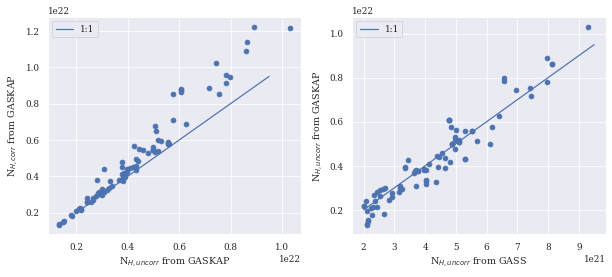

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

nh_range = np.linspace(2,9.5)*1E21

axs[0].scatter(smc_hi_table['nh_uncorr'], smc_hi_table['nh_corr'])

axs[0].plot(nh_range, nh_range, label='1:1')
axs[0].set_xlabel(r'N$_{H,uncorr}$ from GASKAP')
axs[0].set_ylabel(r'N$_{H,corr}$ from GASKAP')
axs[0].legend()

axs[1].scatter(smc_hi_table['nh_gass'], smc_hi_table['nh_uncorr'])
axs[1].plot(nh_range, nh_range, label='1:1')
axs[1].set_xlabel(r'N$_{H,uncorr}$ from GASS')
axs[1].set_ylabel(r'N$_{H,uncorr}$ from GASKAP')
axs[1].legend()

fig.savefig('figures/column_density_correction.png', bbox_inches='tight')


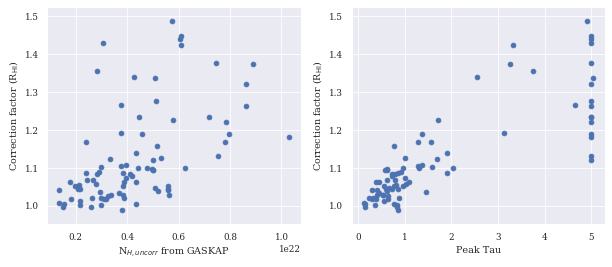

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(smc_hi_table['nh_uncorr'], smc_hi_table['r_hi'])
axs[0].set_xlabel(r'N$_{H,uncorr}$ from GASKAP')
axs[0].set_ylabel(r'Correction factor (R$_{\rm HI}$)')

axs[1].scatter(smc_hi_table['peak_tau'], smc_hi_table['r_hi'])
axs[1].set_xlabel('Peak Tau')
axs[1].set_ylabel(r'Correction factor (R$_{\rm HI}$)')

fig.savefig('figures/column_density_correction_factor.png', bbox_inches='tight')


Text(0.5, 1.0, 'Column Density distribution')

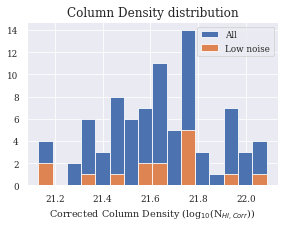

In [12]:
log_nh_corr = np.log10(smc_hi_table['nh_corr'])

fig, ax = plt.subplots(1,1, figsize=(4.5,3))
ax.set_xlabel(r'Corrected Column Density (log$_{10}$(N$_{HI,Corr}$))')

hist, bins, patches = plt.hist(log_nh_corr, bins=16, label='All')
plt.hist(log_nh_corr[smc_very_low_noise_filter], bins=bins, label='Low noise')
plt.gca().legend()
ax.set_title('Column Density distribution', size=12)



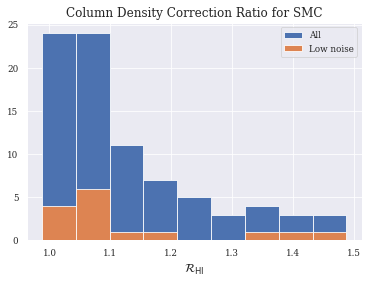

In [13]:
hist, bins, patches = plt.hist(smc_hi_table['r_hi'], bins=9, label='All')
plt.hist(smc_hi_table['r_hi'][smc_very_low_noise_filter], bins=bins, label='Low noise')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'$\mathcal{R}_{\rm HI}$', size=12)
ax.set_title('Column Density Correction Ratio for SMC', size=12)
ax.legend()
plt.savefig('figures/r_hi_hist_smc.png', bbox_inches='tight')

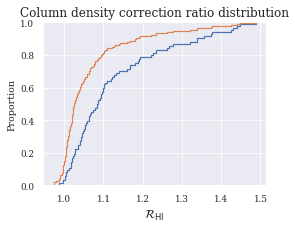

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ecdf = sns.ecdfplot(x=smc_hi_table['r_hi'], complementary=False, ax=ax)#, legend=False)
ecdf = sns.ecdfplot(x=spectra_table['r_hi'], complementary=False, ax=ax)#, legend=False)

ax.set_xlabel(r'$\mathcal{R}_{\rm HI}$', size=12)

ax.set_title('Column density correction ratio distribution', size=12)

plt.savefig('figures/r_hi_cdf_smc.png', bbox_inches='tight')


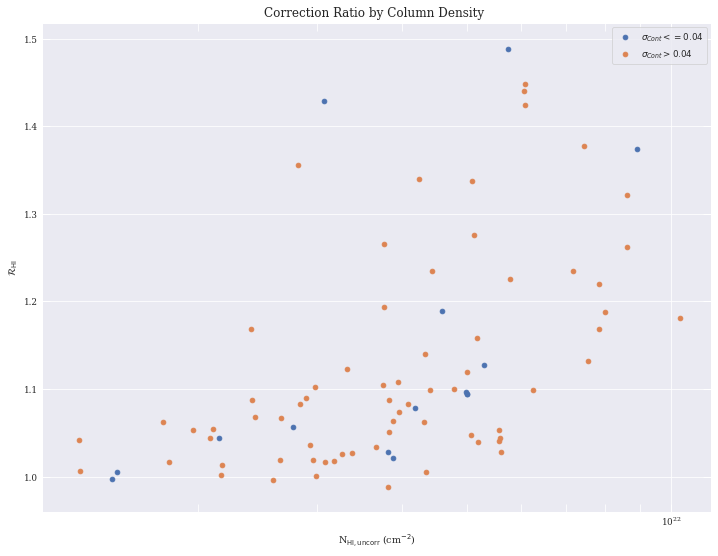

In [15]:

fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(smc_hi_table['nh_uncorr'][smc_very_low_noise_filter], smc_hi_table['r_hi'][smc_very_low_noise_filter], label='$\sigma_{Cont} <= 0.04$')
ax.scatter(smc_hi_table['nh_uncorr'][~smc_very_low_noise_filter], smc_hi_table['r_hi'][~smc_very_low_noise_filter], label='$\sigma_{Cont} > 0.04$')

#ax.scatter(smc_hi_table['nh_img'], smc_hi_table['r_hi'], label='GASS N$_{H}$')



ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_xlim(1e21, 2e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(0.005, 300)
#ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
ax.set_xlabel(r'N$_{\rm HI, uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\mathcal{R}_{\rm HI}$')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=8)
ax.set_title('Correction Ratio by Column Density ', size=12)


ax.legend()
fig.savefig('figures/nh_rhi.png', bbox_inches='tight')

In [16]:
from scipy.optimize import curve_fit

# Fitting lines to the different subsets
def test_line(x, a, b):
    return a + (b * x)

def test_power(x, a, b):
    return a + (x**b)

trimmed_bar_det = bar_det & (spectra_table['nh_uncorr'] > 4e21)
bar_fit, param_cov = curve_fit(test_power, np.log10(spectra_table['nh_uncorr'][trimmed_bar_det]), spectra_table['r_hi'][trimmed_bar_det])
print ("Bar fit = {:.4f} + log10(NH)^{:.4f}".format(bar_fit[0], bar_fit[1]))
#print ("Bar fit = {:.4f} + {:.4f} x log10(NH)".format(bar_fit[0], bar_fit[1]))
wing_fit, param_cov = curve_fit(test_power, np.log10(spectra_table['nh_uncorr'][wing_det]), spectra_table['r_hi'][wing_det])
print ("Wing fit = {:.4f} + log10(NH)^{:.4f}".format(wing_fit[0], wing_fit[1]))

Bar fit = -11.0280 + log10(NH)^0.8118
Wing fit = -15.5914 + log10(NH)^0.9178


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [17]:
bar_fit = np.polyfit(np.log10(spectra_table['nh_uncorr'][trimmed_bar_det]), spectra_table['r_hi'][trimmed_bar_det], 2)
print ("Bar fit = {:.4f}*log10(NH)^2 + {:.4f}*log10(NH) + {:.4f} ".format(bar_fit[0], bar_fit[1], bar_fit[2]))

Bar fit = 1.5231*log10(NH)^2 + -65.9601*log10(NH) + 715.2309 


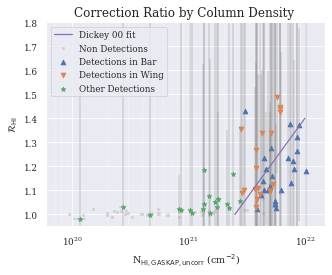

In [49]:

#fig, ax = plt.subplots(1,1, figsize=(6,4.5))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))



log_n_h = np.log10(spectra_table['nh_uncorr'])
e_log_n_h = log_n_h*(spectra_table['e_nh_uncorr']/spectra_table['nh_uncorr'])
#print (e_log_n_h)

#ax.errorbar(spectra_table['nh_uncorr'][non_detect], spectra_table['r_hi'][non_detect], xerr=spectra_table['e_nh_uncorr'][non_detect], yerr=spectra_table['e_r_hi'][non_detect], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(spectra_table['nh_uncorr'][non_detect], spectra_table['r_hi'][non_detect], marker='.', color='lightgray', label='Non Detections')
#ax.errorbar(spectra_table['nh_uncorr'][non_detect], spectra_table['r_hi'][non_detect], xerr=e_log_n_h[non_detect], fmt=".", color='lightgray')

ax.errorbar(spectra_table['nh_uncorr'][bar_det], spectra_table['r_hi'][bar_det], xerr=spectra_table['e_nh_uncorr'][bar_det], yerr=spectra_table['e_r_hi'][bar_det], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(spectra_table['nh_uncorr'][bar_det], spectra_table['r_hi'][bar_det], marker='^', label='Detections in Bar')

ax.errorbar(spectra_table['nh_uncorr'][wing_det], spectra_table['r_hi'][wing_det], xerr=spectra_table['e_nh_uncorr'][wing_det], yerr=spectra_table['e_r_hi'][wing_det], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(spectra_table['nh_uncorr'][wing_det], spectra_table['r_hi'][wing_det], marker='v', label='Detections in Wing')

ax.errorbar(spectra_table['nh_uncorr'][other_det], spectra_table['r_hi'][other_det], xerr=spectra_table['e_nh_uncorr'][other_det], yerr=spectra_table['e_r_hi'][other_det], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(spectra_table['nh_uncorr'][other_det], spectra_table['r_hi'][other_det], marker='*', label='Other Detections')



ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(6E19, 1.5E22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(0.95, 1.8)
#ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
#ax.set_xlabel(r'N$_{\rm HI, uncorr}$ (cm$^{-2}$)')
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\mathcal{R}_{\rm HI}$')
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w')#, length=8)
ax.set_title('Correction Ratio by Column Density ', size=12)
nh_sample = np.linspace(2.5E21, 1E22,1000)
d00_line = 1+0.667*(np.log10(nh_sample)-21.4)
ax.plot(nh_sample, d00_line, label="Dickey 00 fit", c="C4")
#bar_line = bar_fit[0] + bar_fit[1]*(np.log10(nh_sample))
bar_line = bar_fit[2] + bar_fit[1]*(np.log10(nh_sample)) + bar_fit[0]*(np.log10(nh_sample))**2
#ax.plot(nh_sample, bar_line, label="Bar fit", c="C0", ls=':')
#wing_line = wing_fit[0] + wing_fit[1]*(np.log10(nh_sample))
#wing_line = wing_fit[0] + (np.log10(nh_sample))**wing_fit[1]
#ax.plot(nh_sample, wing_line, label="Wing fit", c="C1", ls=':')



plt.grid(True, which="major", ls="-")
plt.grid(True, which="minor", ls=":")

ax.legend(loc='upper left')
fig.savefig('figures/nh_rhi_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_rhi_detections.pdf', bbox_inches='tight')

In [19]:

df = pd.DataFrame(data={'log_nh':np.log10(spectra_table['nh_uncorr'][wing_det | bar_det]), 
                        'r_hi': spectra_table['r_hi'][wing_det | bar_det]})

In [20]:
region = np.full(spectra_table['nh_uncorr'].shape, "Other")
region[wing_det] = "Wing"
region[bar_det] = "Bar"
df['region'] = region[wing_det | bar_det]

/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Bar: log10(NH) min: 21.49 median: 21.75 max: 22.01
Wing: log10(NH) min: 21.45 median: 21.62 max: 21.78
Bar: R_HI min: 1.02 median: 1.16 max: 1.43
Wing: R_HI min: 1.03 median: 1.12 max: 1.49


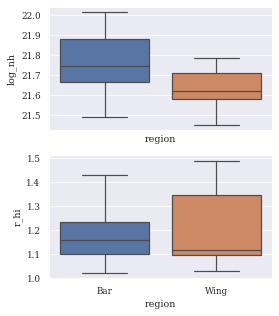

In [21]:
f, axs = plt.subplots(2,1,
                      figsize=(4,5),
                      sharex=True)

ax = sns.boxplot(x="region", y="log_nh", data=df, ax=axs[0])
ax = sns.boxplot(x="region", y="r_hi", data=df, ax=axs[1])

bar_nh = np.log10(spectra_table['nh_uncorr'][bar_det])
print ("Bar: log10(NH) min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(bar_nh), np.median(bar_nh), np.max(bar_nh)))
wing_nh = np.log10(spectra_table['nh_uncorr'][wing_det])
print ("Wing: log10(NH) min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(wing_nh), np.median(wing_nh), np.max(wing_nh)))

bar_rhi = spectra_table['r_hi'][bar_det]
print ("Bar: R_HI min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(bar_rhi), np.median(bar_rhi), np.max(bar_rhi)))
wing_rhi = spectra_table['r_hi'][wing_det]
print ("Wing: R_HI min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(wing_rhi), np.median(wing_rhi), np.max(wing_rhi)))




### Comparison to Galactic Surveys

In [22]:
hdul = fits.open('reference/integrated_properties_comparison.fits') 
comparison_data = hdul[1].data
comparison_data[:2]
sponge = comparison_data['tags']=='SPONGE'
perseus = comparison_data['tags']=='Perseus'
ht03 = comparison_data['tags']=='HT03'

hdul = fits.open('reference/integrated_properties_mach.fits') 
mach_data = hdul[1].data

In [23]:
print (len(comparison_data), np.sum(sponge), np.sum(perseus), np.sum(ht03), len(mach_data))
comparison_data[:2]

103 43 22 38 44


FITS_rec([( 7.67231523, 0.27895691, 6.97869436, 0.24236883, 185.30870236, 0.49059084, 0.25161932, 0.093621  , 1.09939121, 0.05032406,  12.18140738,  37.00643067, 241.18704832,  1.29800611, '3C327.1A', 'SPONGE'),
          (10.55743079, 0.4258176 , 9.55067593, 0.35956501, 191.86620179, 0.30981149, 0.23484189, 0.08802757, 1.1054119 , 0.05532947, 166.63568163, -33.59591844,  49.74084441, 16.47574959, '4C16.09', 'SPONGE')],
         dtype=(numpy.record, [('nhi_iso', '>f8'), ('nhi_iso_err', '>f8'), ('nhi_thin', '>f8'), ('nhi_thin_err', '>f8'), ('intts_abs', '>f8'), ('intts_abs_err', '>f8'), ('fcnm_abs', '>f8'), ('fcnm_abs_err', '>f8'), ('rhi_abs', '>f8'), ('rhi_abs_err', '>f8'), ('l', '>f8'), ('b', '>f8'), ('ra', '>f8'), ('dec', '>f8'), ('names', 'S9'), ('tags', 'S7')]))

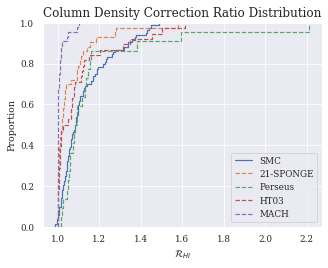

In [24]:
fig, ax = plt.subplots(1,1, figsize=(5,3.75))
rhi = smc_hi_table['r_hi']#[smc_hi_table['has_other_abs']]
ecdf = sns.ecdfplot(x=rhi, complementary=False, ax=ax, legend=False)
for label in ('SPONGE', 'Perseus', 'HT03'):
    comp_filt = comparison_data['tags']==label
    rhi = comparison_data['rhi_abs'][comp_filt].astype('float64')
    sns.ecdfplot(x=rhi, ax=ax, legend=False, ls='--')
sns.ecdfplot(x=mach_data['rhi_abs'].astype('float64'), ax=ax, legend=False, ls='--')

ax.set_xlabel(r'$\mathcal{R}_{HI}$')

ax.set_title('Column Density Correction Ratio Distribution', size=12)
ax.legend(['SMC', '21-SPONGE', 'Perseus', 'HT03', 'MACH'])

plt.savefig('figures/r_hi_cdf_smc_comp.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/r_hi_cdf_smc_comp.pdf', bbox_inches='tight')




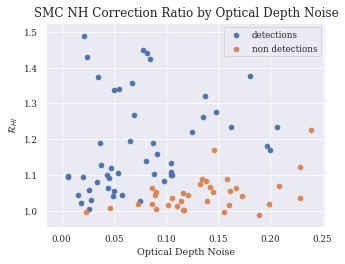

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5,3.75))
rhi = smc_hi_table['r_hi']#[smc_hi_table['has_other_abs']]
sdcont = smc_hi_table['sd_cont']#[smc_hi_table['has_other_abs']]
smc_det = smc_hi_table['has_other_abs']
ax.scatter(sdcont[smc_det], rhi[smc_det], label="detections")
ax.scatter(sdcont[~smc_det], rhi[~smc_det], label="non detections")

ax.set_ylabel(r'$\mathcal{R}_{HI}$')
ax.set_xlabel(r'Optical Depth Noise')
ax.legend()

ax.set_title('SMC NH Correction Ratio by Optical Depth Noise', size=12)

plt.savefig('figures/r_hi_by_noise.png', bbox_inches='tight', dpi=200)

### Equivalent Width and the Kanekar, Braun and Roy 2011 Result

/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


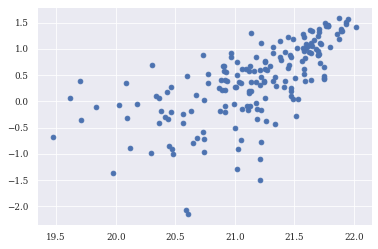

In [26]:
log_ew = np.log10(spectra_table['ew'])
log_nh = np.log10(spectra_table['nh_uncorr'])
plt.scatter(log_nh, log_ew)

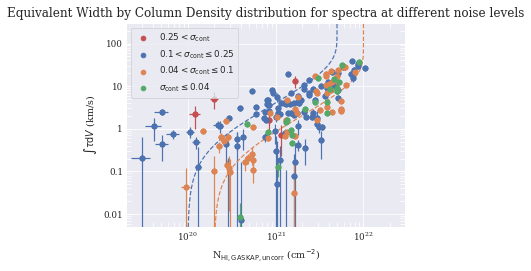

In [27]:

all_nh = spectra_table['nh_uncorr']
all_ew = spectra_table['ew']


tauvals = np.logspace(np.log10(0.005), np.log10(300), 200)
kbr11_lower = 1e20*np.exp(-1*tauvals/20)+5e21*(1-np.exp(-1*tauvals/20))
kbr11_upper = 2e20*np.exp(-1*tauvals/10)+1e22*(1-np.exp(-1*tauvals/10))

# e_nh_uncorr

#fig, ax = plt.subplots(1,1, figsize=(12,9))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))


ax.scatter(all_nh[high_noise_filter], all_ew[high_noise_filter], label=r'$0.25 < \sigma_{\rm cont}$', c='C3')
ax.errorbar(all_nh[high_noise_filter], all_ew[high_noise_filter], yerr=spectra_table['e_peak_tau'][high_noise_filter], fmt="o", c='C3')
ax.errorbar(all_nh[high_noise_filter], all_ew[high_noise_filter], xerr=spectra_table['e_nh_uncorr'][high_noise_filter], fmt="o", c='C3')


ax.scatter(all_nh[mid_noise_filter], all_ew[mid_noise_filter], label=r'$0.1 < \sigma_{\rm cont} \leq 0.25$')
ax.errorbar(all_nh[mid_noise_filter], all_ew[mid_noise_filter], yerr=spectra_table['e_peak_tau'][mid_noise_filter], fmt="o", c='C0')
ax.errorbar(all_nh[mid_noise_filter], all_ew[mid_noise_filter], xerr=spectra_table['e_nh_uncorr'][mid_noise_filter], fmt="o", c='C0')


ax.scatter(all_nh[low_noise_filter], all_ew[low_noise_filter], label=r'$0.04 < \sigma_{\rm cont} \leq 0.1$')
ax.errorbar(all_nh[low_noise_filter], all_ew[low_noise_filter], yerr=spectra_table['e_peak_tau'][low_noise_filter], fmt="o", c='C1')
ax.errorbar(all_nh[low_noise_filter], all_ew[low_noise_filter], xerr=spectra_table['e_nh_uncorr'][low_noise_filter], fmt="o", c='C1')


ax.scatter(all_nh[very_low_noise_filter], all_ew[very_low_noise_filter], label=r'$\sigma_{\rm cont} \leq 0.04$')
ax.errorbar(all_nh[very_low_noise_filter], all_ew[very_low_noise_filter], yerr=spectra_table['e_peak_tau'][very_low_noise_filter], fmt="o", c='C2')
ax.errorbar(all_nh[very_low_noise_filter], all_ew[very_low_noise_filter], xerr=spectra_table['e_nh_uncorr'][very_low_noise_filter], fmt="o", c='C2')


#ax.scatter(all_nh[detection_filter], all_ew[detection_filter], label=r'Detections', c='C4', marker='*', s=100)
#ax.errorbar(all_nh[detection_filter], all_ew[detection_filter], yerr=spectra_table['e_peak_tau'][detection_filter], fmt="*", c='C4')




ax.plot(kbr11_lower, tauvals, ls='--')
ax.plot(kbr11_upper, tauvals, ls='--')

ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(0.005, 300)
ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\int \tau {\rm d}V$ (km/s)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
ax.set_title('Equivalent Width by Column Density distribution for spectra at different noise levels', size=12)


ax.legend()
fig.savefig('figures/nh_ew_kbr11.png', bbox_inches='tight')

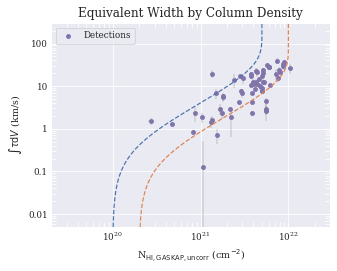

In [28]:

tauvals = np.logspace(np.log10(0.005), np.log10(300), 200)
kbr11_lower = 1e20*np.exp(-1*tauvals/20)+5e21*(1-np.exp(-1*tauvals/20))
kbr11_upper = 2e20*np.exp(-1*tauvals/10)+1e22*(1-np.exp(-1*tauvals/10))

#fig, ax = plt.subplots(1,1, figsize=(12,9))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))

ax.scatter(all_nh[detections], all_ew[detections], label=r'Detections', c='C4', s=16)#, marker='*')#, s=60)
ax.errorbar(all_nh[detections], all_ew[detections], xerr=spectra_table['e_nh_uncorr'][detections], yerr=spectra_table['e_ew'][detections], color='grey', fmt='none', zorder=1, elinewidth=0.4)



ax.plot(kbr11_lower, tauvals, ls='--')
ax.plot(kbr11_upper, tauvals, ls='--')

ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(0.005, 300)
ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\int \tau {\rm d}V$ (km/s)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
ax.set_title('Equivalent Width by Column Density', size=12)

ax.legend()

fig.savefig('figures/nh_ew_kbr11_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_ew_kbr11_detections.pdf', bbox_inches='tight')

### Mean Spin Temperatures

/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of Spin Temperatures')

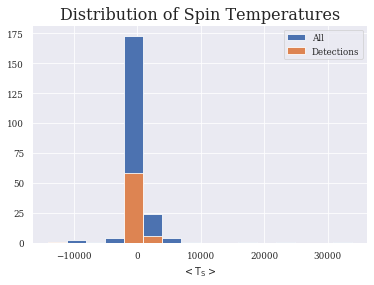

In [29]:

hist, bins, patches = plt.hist(spectra_table['mean_ts'], bins=16, label='All')
plt.hist(spectra_table['mean_ts'][detections], bins=bins, label='Detections')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'$<{\rm T}_{\rm S}>$')
#ax.set_title('Column Density Correction Ratio for SMC')
ax.legend()
#plt.savefig('figures/r_hi_hist_smc.png', bbox_inches='tight')
ax.set_title('Distribution of Spin Temperatures', size=16)


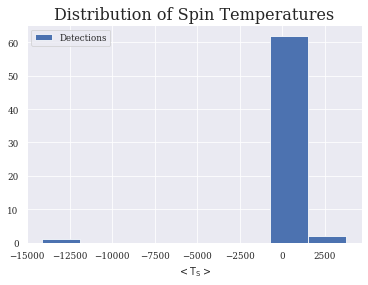

In [30]:
plt.hist(spectra_table['mean_ts'][detections], bins=8, label='Detections')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'$<{\rm T}_{\rm S}>$')
ax.set_title('Distribution of Spin Temperatures', size=16)

ax.legend()
plt.savefig('figures/ts_hist_detections.png', bbox_inches='tight')



/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


Note there are 58 spin temperatures below 1 that are not shown!
>> J012336-703232 [noise=0.249] has T_s=-110.385
>> J003530-723655 [noise=0.261] has T_s=-388.876
>> J010524-731518 [noise=0.189] has T_s=-615.773
>> J005503-712107 [noise=0.206] has T_s=-536.789
>> J005115-713058 [noise=0.213] has T_s=-151.264
>> J004027-703513 [noise=0.186] has T_s=-2108.948
>> J012321-703741 [noise=0.186] has T_s=-1006.165
>> J005539-721049 [noise=0.114] has T_s=-9809.049
>> J013134-700042 [noise=0.108] has T_s=-49.899
>> J002631-741314 [noise=0.229] has T_s=-690.790
>> J013147-734942 [noise=0.155] has T_s=-660.475
>> J003749-735128 [noise=0.156] has T_s=-822.340
>> J012758-720535 [noise=0.254] has T_s=-406.740
>> J005848-743514 [noise=0.224] has T_s=-204.844
>> J013124-713341 [noise=0.184] has T_s=-198.698
>> J003224-730700 [noise=0.226] has T_s=-222.133
>> J012330-721815 [noise=0.139] has T_s=-291.430
>> J004318-714100 [noise=0.161] has T_s=-651.892
>> J011436-715236 [noise=0.160] has T_s=-2834.800
>>

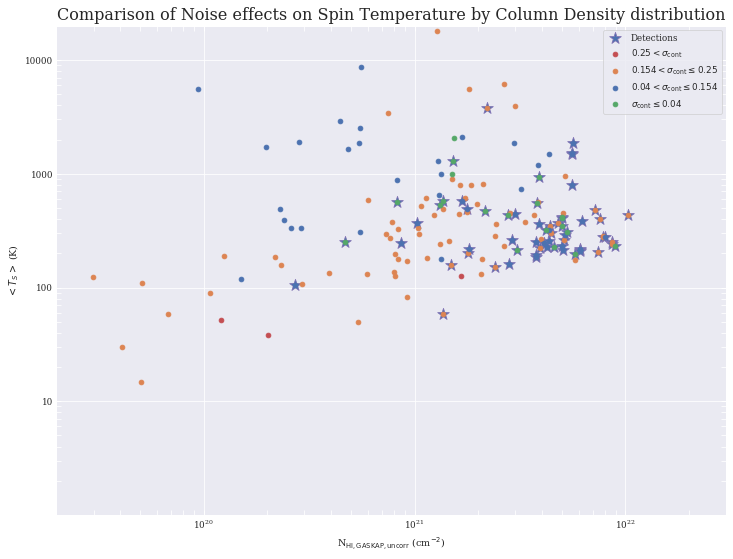

In [31]:
all_mean_ts = spectra_table['mean_ts']
all_nh = spectra_table['nh_uncorr']

fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(all_nh[detections], all_mean_ts[detections], label=r'Detections', c=None, edgecolor='C4', marker='*', s=150)
#ax.scatter(all_nh, all_mean_ts) #, label=r'Detections', c='C4', marker='*', s=100)
ax.scatter(all_nh[high_noise_filter], all_mean_ts[high_noise_filter], label=r'$0.25 < \sigma_{\rm cont}$', c='C3')

ax.scatter(all_nh[mid_noise_filter], all_mean_ts[mid_noise_filter], label=r'$0.154 < \sigma_{\rm cont} \leq 0.25$', c='C1')

ax.scatter(all_nh[low_noise_filter], all_mean_ts[low_noise_filter], label=r'$0.04 < \sigma_{\rm cont} \leq 0.154$', c='C0')

ax.scatter(all_nh[very_low_noise_filter], all_mean_ts[very_low_noise_filter], label=r'$\sigma_{\rm cont} \leq 0.04$', c='C2')



ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(1, 20000)
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$<T_S>$ (K)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
ax.legend()
ax.set_title('Comparison of Noise effects on Spin Temperature by Column Density distribution', size=16)

if np.sum(all_mean_ts<1):    
    print ("Note there are {} spin temperatures below 1 that are not shown!".format(np.sum(all_mean_ts<1)))
    for source in spectra_table[all_mean_ts<1]:
        print ('>> {} [noise={:.3f}] has T_s={:.3f}'.format(source['comp_name'], source['sd_cont'], source['mean_ts']))


Note there are 2 spin temperatures below 50 that are not shown!
>> J013134-700042 [noise=0.108] has T_s=-49.899
>> J013701-730415 [noise=0.036] has T_s=-14117.649


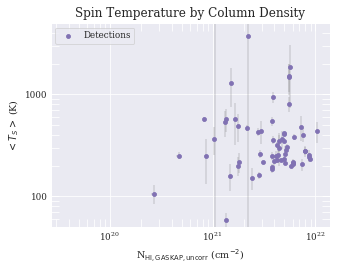

In [32]:
det_mean_ts = spectra_table['mean_ts'][detections]
det_nh = spectra_table['nh_uncorr'][detections]

#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))



ax.errorbar(det_nh, det_mean_ts, xerr=spectra_table['e_nh_uncorr'][detections], yerr=spectra_table['e_mean_ts'][detections], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(det_nh, det_mean_ts, label=r'Detections', c='C4', s=16) #, marker='*')#, s=100)


ts_floor = 50
ts_ceil = 5000
ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(ts_floor, ts_ceil)
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$<T_S>$ (K)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=8)
ax.set_yticklabels(labels=['', '10', '100', '1000'])
ax.legend(loc='upper left')
ax.set_title('Spin Temperature by Column Density', size=12)

fig.savefig('figures/nh_mean_ts_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_mean_ts_detections.pdf', bbox_inches='tight')


if np.sum(det_mean_ts<ts_floor) > 0:    
    print ("Note there are {} spin temperatures below {} that are not shown!".format(np.sum(det_mean_ts<ts_floor), ts_floor))
    for source in spectra_table[detections][det_mean_ts<ts_floor]:
        print ('>> {} [noise={:.3f}] has T_s={:.3f}'.format(source['comp_name'], source['sd_cont'], source['mean_ts']))

        
if np.sum(det_mean_ts>ts_ceil) > 0:    
    print ("Note there are {} spin temperatures above {} that are not shown!".format(np.sum(det_mean_ts>ts_ceil), ts_ceil))
    for source in spectra_table[detections][det_mean_ts>ts_ceil]:
        print ('>> {} [noise={:.3f}] has T_s={:.3f}'.format(source['comp_name'], source['sd_cont'], source['mean_ts']))




### Cool gas fraction

f_c = N_c / (N_w + N_c)

n_c ~~ f_c N_unc

<T_s> = T_c / f_c

f_c = T_c / <T_s>

In [33]:
t_cool = 30
fraction_cool = t_cool/spectra_table['mean_ts']

/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Median mean spin temp SMC 30.00
Median cold gas fraction SMC TC=30K 0.10


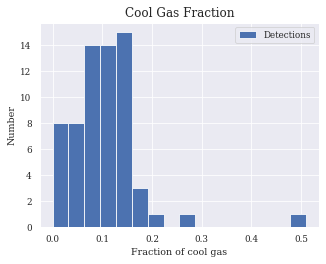

In [34]:
print ("Median mean spin temp SMC {:.2f}".format(t_cool, np.median(spectra_table['mean_ts'][detections])))

print ("Median cold gas fraction SMC TC={}K {:.2f}".format(t_cool, np.median(fraction_cool[detections])))
det_cool_gas_frac = np.array(fraction_cool[detections])
det_cool_gas_frac[det_cool_gas_frac>1] = 1
det_cool_gas_frac[det_cool_gas_frac<0] = 0

all_cool_gas_frac = np.array(fraction_cool)
all_cool_gas_frac[all_cool_gas_frac>1] = 1
all_cool_gas_frac[all_cool_gas_frac<0] = 0


fig, ax = plt.subplots(1,1, figsize=(5,3.75))

#n, bins, patches = ax.hist(all_cool_gas_frac, bins=16, label='All')
ax.hist(det_cool_gas_frac, bins=16, label='Detections', color='C0')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'Fraction of cool gas')
ax.set_ylabel(r'Number')

ax.set_title('Cool Gas Fraction', size=12)

ax.legend()

plt.savefig('figures/fraction_cool_hist_detections.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/fraction_cool_hist_detections.pdf', bbox_inches='tight')


Text(0.5, 1.0, 'Cool Gas Fraction by Column Density distribution')

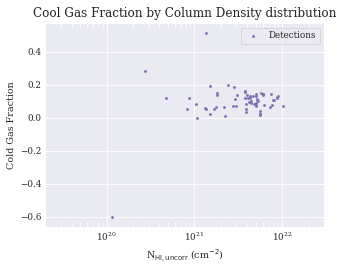

In [35]:
det_nh = spectra_table['nh_uncorr'][detections]

fig, ax = plt.subplots(1,1, figsize=(5,3.75))

ax.scatter(det_nh, fraction_cool[detections], label=r'Detections', c='C4', marker='.', s=16)

ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(ts_floor, ts_ceil)
ax.set_xlabel(r'N$_{\rm HI, uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'Cold Gas Fraction')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
ax.legend()
ax.set_title('Cool Gas Fraction by Column Density distribution', size=12)



### Effects of Optical Depth Noise

Text(0.5, 1.0, 'Comparison of Spin Temperature by Optical Depth Noise')

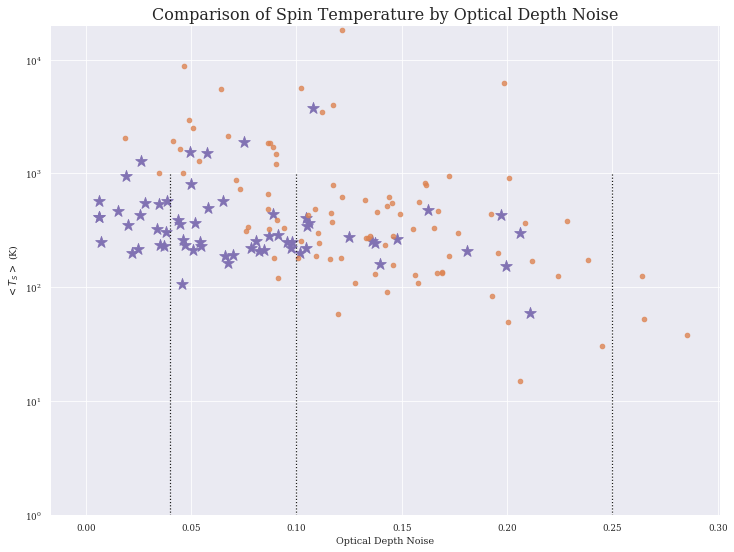

In [36]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(spectra_table['sd_cont'][detections], spectra_table['mean_ts'][detections], label=r'Detections', c='C4', marker='*', s=150)
ax.scatter(spectra_table['sd_cont'][~detections], spectra_table['mean_ts'][~detections], label=r'Non Detections', alpha=0.8, c='C1')



#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
##ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(1, 20000)
ax.set_xlabel(r'Optical Depth Noise')
ax.set_ylabel(r'$<T_S>$ (K)')

ax.vlines([0.04,0.1,0.25], -50, 1000, ls=':')
#ax.set_ylim(-20, 1000)
#ax.set_xlim(0, 1.4)
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
#ax.legend()
ax.set_title('Comparison of Spin Temperature by Optical Depth Noise', size=16)





[0.00614439 0.03718671 0.06822902 0.09927133 0.13031365 0.16135596
 0.19239828 0.22344059 0.25448291 0.28552522]


Text(0.5, 1.0, 'Optical Depth Noise Distribution')

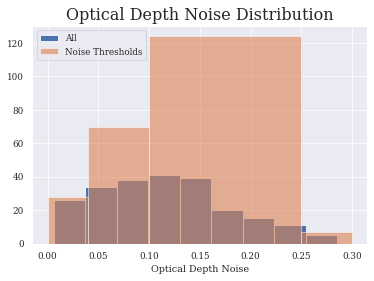

In [37]:
hist, bins, patches = plt.hist(spectra_table['sd_cont'], bins=9, label='All')
plt.hist(spectra_table['sd_cont'], bins=[0,0.04,0.1,0.25,0.3], label='Noise Thresholds', alpha=0.6)
#plt.hist(all_mean_ts[smc_very_low_noise_filter], bins=bins, label='Low noise')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'Optical Depth Noise')

#ax.set_xlabel(r'$<{\rm T}_{\rm S}>$')
print (bins)
ax.legend()
ax.set_title('Optical Depth Noise Distribution', size=16)


Text(0.5, 1.0, 'Comparison of Peak Flux vs Optical Depth Noise')

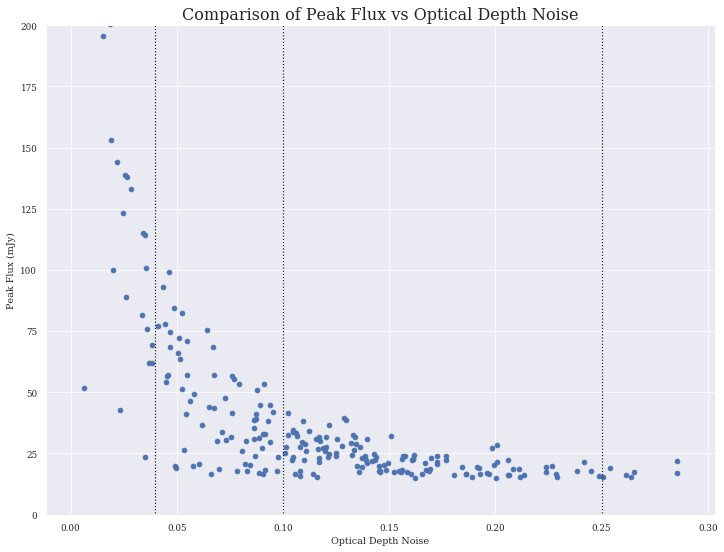

In [38]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(spectra_table['sd_cont'], spectra_table['flux_peak']) #, label=r'Detections', c='C4', marker='*', s=100)


#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
##ax.set_xlim(2e19, 3e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(1, 20000)
ax.set_xlabel(r'Optical Depth Noise')
ax.set_ylabel(r'Peak Flux (mJy)')

ax.vlines([0.04,0.1,0.25], -50, 1000, ls=':')
ax.set_ylim(0, 200)
#ax.set_xlim(0, 1.4)
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
#ax.legend()

ax.set_title('Comparison of Peak Flux vs Optical Depth Noise', size=16)





Text(0.5, 1.0, 'Comparison of Equivalent Width by Optical Depth Noise')

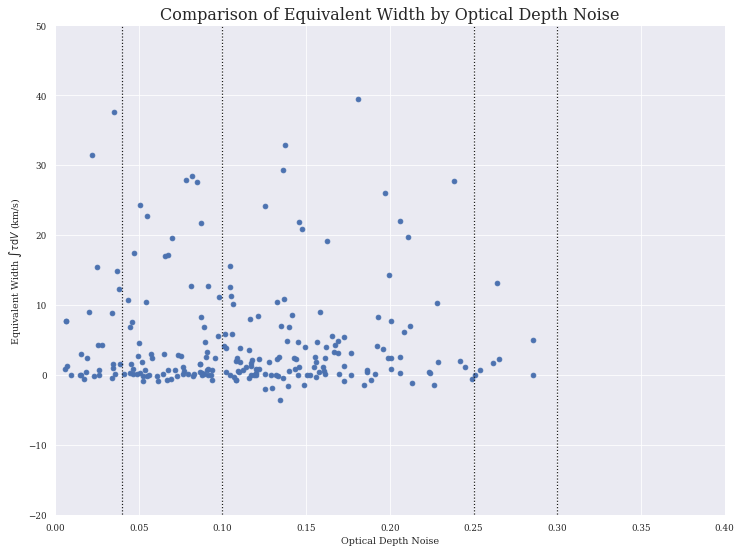

In [39]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(spectra_table['sd_cont'], all_ew) #, label=r'Detections', c='C4', marker='*', s=100)


#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
##ax.set_xlim(2e19, 3e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(1, 20000)
ax.set_xlabel(r'Optical Depth Noise')
ax.set_ylabel(r'Equivalent Width $\int \tau {\rm d}V$ (km/s)')

ax.vlines([0.04,0.1,0.25, 0.3], -50, 1000, ls=':')
ax.set_ylim(-20, 50)
ax.set_xlim(0, 0.4)
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
#ax.legend()

ax.set_title('Comparison of Equivalent Width by Optical Depth Noise', size=16)






### Comparison plots of the effect of smoothing

In [40]:
all_ew_no_smooth = np.empty((0))
all_mean_ts_no_smooth = np.empty((0))
all_sd_cont_no_smooth = np.empty((0))

for idx, source in enumerate(spectra_table):
    if idx % 50 == 0:
        print ('processing record {} of {}'.format(idx+1, len(spectra_table)))
    #img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source, 'sb10944/v3a/spectra', smooth_thresh=5)
    spectra_stats = process_spectrum(source, 'sb10944/v3a/spectra', smooth_thresh=5)

    all_ew_no_smooth = np.append(all_ew_no_smooth, spectra_stats.ew)
    all_mean_ts_no_smooth = np.append(all_mean_ts_no_smooth, spectra_stats.mean_ts)
    all_sd_cont_no_smooth = np.append(all_sd_cont_no_smooth, spectra_stats.sd_cont)


processing record 1 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: in

processing record 51 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: Runtime

processing record 101 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipyker

processing record 151 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value enco

processing record 201 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.p

In [41]:
all_ew_alt_smooth = np.empty((0))
all_mean_ts_alt_smooth = np.empty((0))
all_sd_cont_alt_smooth = np.empty((0))

for idx, source in enumerate(spectra_table):
    if idx % 50 == 0:
        print ('processing record {} of {}'.format(idx+1, len(spectra_table)))
    #img_nh, tot_nh, tot_corr_nh, r_hi, ew, mean_ts, sd_cont, f_int_v = process_spectrum(source, 'sb10944/v3a/spectra', smooth_thresh=0.1)
    spectra_stats = process_spectrum(source, 'sb10944/v3a/spectra', smooth_thresh=0.1)

    all_ew_alt_smooth = np.append(all_ew_alt_smooth, spectra_stats.ew)
    all_mean_ts_alt_smooth = np.append(all_mean_ts_alt_smooth, spectra_stats.mean_ts)
    all_sd_cont_alt_smooth = np.append(all_sd_cont_alt_smooth, spectra_stats.sd_cont)



processing record 1 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: Runtime

processing record 51 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: Runtime

processing record 101 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packa

processing record 151 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value enco

processing record 201 of 229


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.p

Text(0.5, 1.0, 'Effect of smoothing on Optical Depth Noise')

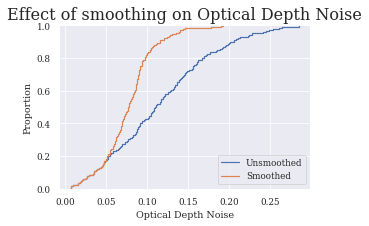

In [42]:
# optical depth noise CDF comparison

fig, ax = plt.subplots(1,1, figsize=(4.5,3))
ecdf = sns.ecdfplot(x=spectra_table['sd_cont'], ax=ax, label='Unsmoothed')#, legend=False)
ecdf = sns.ecdfplot(x=all_sd_cont_alt_smooth, ax=ax, label='Smoothed')#, legend=False)
#ecdf = sns.ecdfplot(x=all_sd_cont_alt_smooth, ax=ax, label='Less Smoothed')#, legend=False)


ax.set_xlabel(r'Optical Depth Noise')
ax.legend()
ax.set_title('Effect of smoothing on Optical Depth Noise', size=16)

Text(0.5, 1.0, 'Effect of smoothing on Equivalent Width')

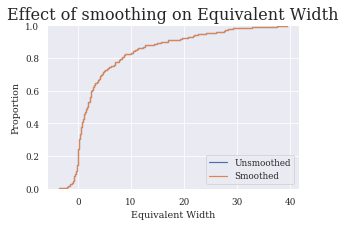

In [43]:
# Equivalent width CDF comparison

fig, ax = plt.subplots(1,1, figsize=(4.5,3))
ecdf = sns.ecdfplot(x=all_ew_no_smooth, ax=ax, label='Unsmoothed')#, legend=False)
ecdf = sns.ecdfplot(x=all_ew, ax=ax, label='Smoothed')#, legend=False)

ax.set_xlabel(r'Equivalent Width')
ax.legend()
ax.set_title('Effect of smoothing on Equivalent Width', size=16)

Text(0.5, 1.0, 'Comparison of the effect of smoothing on Equivalent Width against Optical Depth Noise')

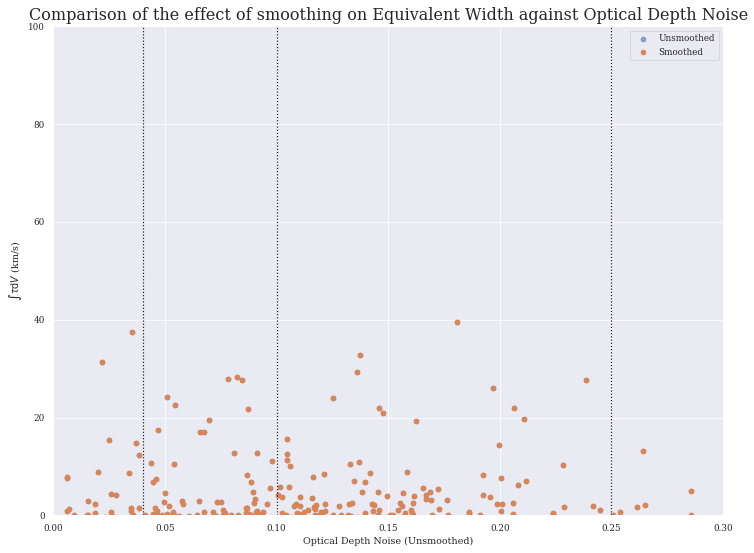

In [44]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

ax.scatter(spectra_table['sd_cont'], all_ew_no_smooth, label=r'Unsmoothed', c='C0', alpha=0.6)
ax.scatter(spectra_table['sd_cont'], all_ew, label=r'Smoothed', c='C1')



#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
##ax.set_xlim(2e19, 3e22)
#ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_ylim(1, 20000)
ax.set_xlabel(r'Optical Depth Noise (Unsmoothed)')
ax.set_ylabel(r'$\int \tau {\rm d}V$ (km/s)')
ax.vlines([0.04,0.1,0.25], -50, 200, ls=':')
ax.set_ylim(0, 100)
ax.set_xlim(0, 0.3)
#ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
#ax.set_yticklabels(labels=['', '', '10', '100', '1000', '10000'])
ax.legend()
ax.set_title('Comparison of the effect of smoothing on Equivalent Width against Optical Depth Noise', size=16)


### Scratch

In [45]:
smc_hi_table

id,comp_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,nh_gass,noise_flag,beam_power,nh_uncorr,e_nh_uncorr,nh_corr,e_nh_corr,r_hi,e_r_hi,f_int,mean_ts,e_mean_ts,ew,e_ew,num_chan
,,deg,deg,,mJy/beam,mJy/beam,,,,,,,km / s,,,,,arcsec,arcsec,deg,1 / cm2,,,1 / cm2,1 / cm2,1 / cm2,1 / cm2,,,,,,km / s,km / s,
int64,str32,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,bool,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13,J005535-723533,13.899411,-72.592574,C,15.053000450134277,8.522021817043423e-05,0.16227310227980046,1.856298565864563,2.5452221979121297,1.5236057043075562,93.0,-0.33269286155700684,113.61597766529509,5.0,3.6192534660730047,False,True,5.552000045776367,4.431999969482422,140.7100067138672,7.446596934360939e+21,False,0.9928809,7.168075769842141e+21,6.882111346062339e+19,8.849933566255248e+21,7.506460516839686e+21,1.2346316989964163,1.0472742812083333,1.2346316762881915,479.813134319267,133.97543181286656,19.196941375732422,6.2080041500671514,94.0
17,J010524-731518,16.350785,-73.255016,B,15.25100040435791,0.00016707086469978095,0.18895516231333526,1.185164451599121,0.9452755957894506,1.609252691268921,71.0,0.4240882992744446,337.83696333942095,0.8578135967254639,0.36849414393947005,False,False,4.072000122070313,3.295999908447266,138.88999938964844,4.025576393206028e+21,False,0.9779848,3.81419095259338e+21,5.171520017685217e+19,3.767409615821347e+21,2.0744220427731033e+21,0.9877349253476088,0.5440343406013217,0.9877349037906726,-615.7734240782548,429.7294792175424,-0.724483072757721,2.9733617815861435,88.0
19,J005448-725353,13.702572,-72.898137,C,15.98799991607666,0.00015485620824620127,0.18070838215007914,2.211228370666504,2.0076773559084584,1.7351946830749512,52.0,-0.4760337173938751,165.777135904169,5.0,3.821651016570783,False,True,3.8840000152587892,3.2680000305175785,137.1300048828125,6.945996611979021e+21,False,0.9740377,7.434644351591776e+21,7.2852277593603826e+19,1.0239162822324946e+22,4.48234355870555e+21,1.3772229494922261,0.6030505501023355,1.377222923479955,205.99460310023636,28.62717259367147,39.44877243041992,5.831247394519753,106.0
26,J010532-721331,16.386939,-72.225495,C,16.305999755859375,0.00013356159906834363,0.20625884450647666,1.7323534488677979,1.4747387200154491,1.7000147104263306,105.0,-0.03233879804611206,132.31849058601603,5.0,3.59348986463798,False,True,3.7759998321533206,3.2279998779296877,138.6999969482422,4.38220123668127e+21,False,1.0038936,4.4384762865350607e+21,7.2039760725133476e+19,5.47996953122367e+21,7.382534874828215e+22,1.2346510778593482,16.63305097553029,1.2346510626390081,301.1693737487198,101.5858862525601,22.02191162109375,5.36387315465491,90.0
32,J010901-731815,17.254612,-73.304389,C,17.288999557495117,0.0001682570087723434,0.1583189635960427,1.5338133573532104,1.245602080922636,1.6830298900604248,94.0,0.14921654760837555,140.82653182734398,1.902356743812561,0.8666307940406985,False,False,3.8200000762939457,3.2560001373291017,142.14999389648438,3.9637131018821535e+21,False,0.97394186,3.837653044522724e+21,4.911668802577518e+19,4.1723100134138996e+21,3.2498397072084104e+22,1.087203549932377,8.468311378614217,1.0872035212036557,560.6106051084796,295.35776056573087,8.93443489074707,3.1629923978228653,89.0
33,J005014-730326,12.561714,-73.057288,C,16.516000747680664,0.00013204875867813825,0.19689896771242069,1.833931803703308,1.7889600056779422,1.657568335533142,83.0,-0.17636345326900482,156.91375551519,5.0,3.878704994296605,False,True,4.231999969482422,3.7040000915527345,124.37999725341797,9.285400120443429e+21,False,0.98851216,1.0306313355637616e+22,7.691676000600424e+19,1.2170477259292768e+22,1.3667480257627976e+22,1.1808759193834761,1.3261562686449737,1.180875894300468

In [46]:
power_pat = fits.open('sb10944/SMC_PB_pattern_full.fits')
power_wcs = WCS(power_pat[0].header).celestial
pix_pos = power_wcs.wcs_world2pix(spectra_table['ra'], spectra_table['dec'], 0)
power_vals = power_pat[0].data[0, 0, pix_pos[1].astype(int), pix_pos[0].astype(int)]
#spectra_table['beam_str'] = power_vals

In [47]:
power_vals

array([1.0359205 , 0.88999236, 1.0161469 , 0.95265865, 0.9928809 ,
       1.0374693 , 0.9938403 , 0.9779848 , 0.9740377 , 1.0103136 ,
       1.0223153 , 1.0828041 , 0.9983869 , 1.0038936 , 0.97394186,
       0.98851216, 0.93052304, 1.0550269 , 1.0749328 , 0.98933506,
       0.9894878 , 0.82688606, 0.9244768 , 1.0281608 , 0.83402336,
       0.81774294, 0.80100965, 0.9934467 , 1.003458  , 1.0699378 ,
       1.0315963 , 1.0069876 , 0.9911685 , 1.0897183 , 0.995317  ,
       1.0589905 , 0.99034   , 0.9759179 , 0.8670541 , 1.0041966 ,
       0.983715  , 1.0658011 , 1.0522277 , 0.98675215, 0.98470074,
       0.9844527 , 0.9354131 , 1.0211432 , 1.0577595 , 1.0805346 ,
       0.997079  , 0.8595847 , 1.0360075 , 1.0013387 , 1.0020278 ,
       1.0006573 , 1.0498728 , 0.83047044, 0.8336172 , 1.042029  ,
       1.0448949 , 1.045168  , 1.0447441 , 0.8143471 , 0.9943588 ,
       1.0048095 , 1.0048033 , 1.0048845 , 1.0354832 , 1.0026028 ,
       1.0829678 , 1.0701178 , 1.0457401 , 1.0608368 , 0.97010

In [48]:
regions = Region.read('smc-reg.reg', format='ds9')

NameError: name 'Region' is not defined

In [ ]:
from regions import RegionList

In [ ]:
from regions import ds9
from astropy.coordinates import SkyCoord
smc_reg = regions.ds9.read.read_ds9('smc-reg.reg')
p = SkyCoord(14*u.deg, -73*u.deg, frame='fk5')

In [ ]:
wing = smc_reg[0]
header = fits.getheader('SMC_askap_parkes_wsclean_PBC_K.fits')
w = WCS(header)

In [ ]:
wing.contains(p, w)

In [ ]:
smc_reg